改版: 使用LSTM、以第t日VIX指數預測第t+1日至第t+30日S&P500指數報酬率的標準差

### 1. 引入套件

In [108]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

### 2. 下載^VIX和^GSPC資料
時間區間為2010-01-01至2024-12-31

In [109]:
start_date = '2014-01-01'
end_date = '2024-12-31'

vix = yf.download('^VIX', start=start_date, end=end_date, progress=False)
gspc = yf.download('^GSPC', start=start_date, end=end_date, progress=False)

In [110]:
vix.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,,
2014-01-02,14.23,14.23,14.59,14.00,14.32,0
2014-01-03,13.76,13.76,14.22,13.57,14.06,0
2014-01-06,13.55,13.55,14.00,13.22,13.41,0
2014-01-07,12.92,12.92,13.28,12.16,12.38,0
2014-01-08,12.87,12.87,13.24,12.86,13.04,0


In [111]:
gspc.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2014-01-02,1831.979980,1831.979980,1845.859985,1827.739990,1845.859985,3080600000
2014-01-03,1831.369995,1831.369995,1838.239990,1829.130005,1833.209961,2774270000
2014-01-06,1826.770020,1826.770020,1837.160034,1823.729980,1832.310059,3294850000
2014-01-07,1837.880005,1837.880005,1840.099976,1828.709961,1828.709961,3511750000
2014-01-08,1837.489990,1837.489990,1840.020020,1831.400024,1837.900024,3652140000


### 3. 資料預處理

In [112]:
gspc['Daily_Return'] = gspc['Adj Close'].pct_change()
gspc['Rolling_Std_30'] = gspc['Daily_Return'].rolling(window=30).std().shift(-29)

In [113]:
data = pd.DataFrame({'VIX_Adj_Close': vix['Adj Close'].values.ravel(), 'GSPC_Rolling_Std': gspc['Rolling_Std_30'].values.ravel()}, index=gspc.index).dropna()

In [114]:
data

,VIX_Adj_Close,GSPC_Rolling_Std
Date,,
2014-01-03,13.760000,0.008947
2014-01-06,13.550000,0.008949
2014-01-07,12.920000,0.009020
2014-01-08,12.870000,0.009019
2014-01-09,12.890000,0.009026
...,...,...
2024-11-11,14.970000,0.007533
2024-11-12,14.710000,0.007802
2024-11-13,14.020000,0.007780


### 4. LSTM模型訓練

4.1 模型訓練、測試資料預測與MSE計算函數

In [115]:
# 4. 使用LSTM模型進行預測
def Model_LSTM(train_data, test_data):
  # 特徵與目標
  X_train = train_data[['VIX_Adj_Close']].values
  y_train = train_data['GSPC_Rolling_Std'].values
  X_test = test_data[['VIX_Adj_Close']].values
  y_test = test_data['GSPC_Rolling_Std'].values

  # 特徵縮放
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  scaler_y = MinMaxScaler(feature_range=(0, 1))

  X_train_scaled = scaler_X.fit_transform(X_train)
  y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
  X_test_scaled = scaler_X.transform(X_test)
  y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

  # 建立LSTM模型
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_scaled.shape[1], 1)))
  model.add(Dense(units=1))

  # 編譯與訓練模型
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32)

  # 預測
  y_pred_scaled = model.predict(X_test_scaled)

  # 反向縮放預測結果與實際結果
  y_pred = scaler_y.inverse_transform(y_pred_scaled)
  y_test_actual = scaler_y.inverse_transform(y_test_scaled)

  mse = mean_squared_error(y_test_actual, y_pred)

  return y_pred, y_test_actual, mse

4.4 預測資料與測試資料作圖函數

In [116]:
# 5. 畫圖顯示預測與實際結果
def Plot_LSTM(predictions_rescaled, y_test_rescaled, Index, k):
  plt.figure(figsize=(10, 6))
  plt.plot(Index, y_test_rescaled, label='Actual GSPC Rolling Std', color='blue')
  plt.plot(Index, predictions_rescaled, label='Predicted GSPC Rolling Std', color='red', linestyle='dashed')
  plt.legend()
  plt.title('LSTM Model: Predicting GSPC Rolling Std from VIXin 2024 with ' + k + 'year(s)')
  plt.xlabel('Date')
  plt.ylabel('Rolling Std')
  plt.show()

### 5. 結果

5.1 1年訓練、1年測試

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2974
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2701 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2391 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1802 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1584 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1556 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1100 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0978 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0788 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0576 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0570 
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482 
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0441 
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

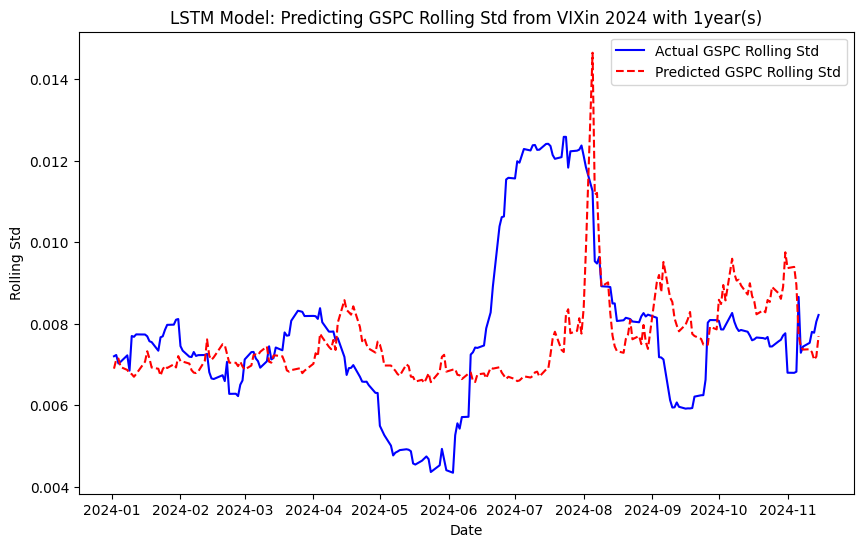

In [117]:
train_data_1 = data['2023-01-01':'2023-12-31']
test_data_1 = data['2024-01-01':]

predictions_rescaled, y_test_rescaled, mse = Model_LSTM(train_data_1, test_data_1)

print('Mean Squared Error:', mse)

Plot_LSTM(predictions_rescaled, y_test_rescaled, test_data_1.index, '1')

5.2 5年訓練、1年測試

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0312
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197
Epoch 13/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 14/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183
Epoch 15/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0152
Epoch 16/50
40/40 ━━━━━━━━━━━━

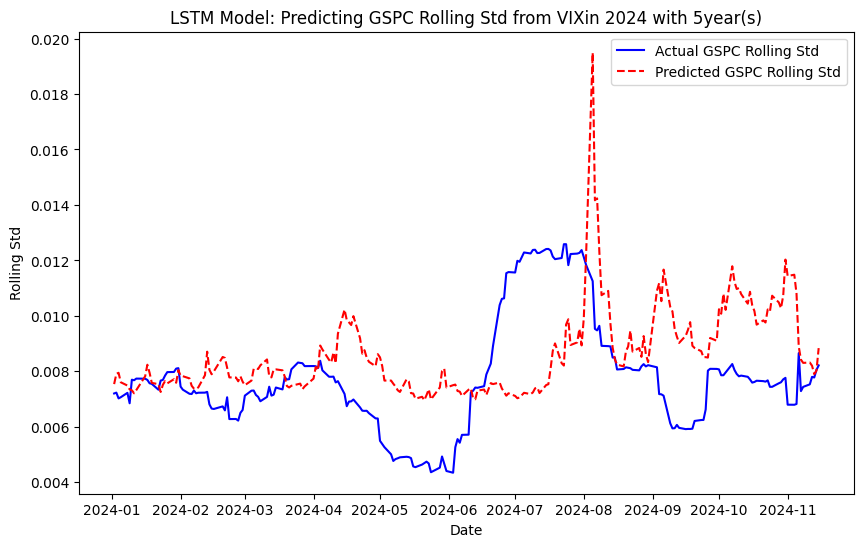

In [118]:
train_data_5 = data['2019-01-01':'2023-12-31']
test_data_1 = data['2024-01-01':]

predictions_rescaled, y_test_rescaled, mse = Model_LSTM(train_data_5, test_data_1)

print('Mean Squared Error:', mse)

Plot_LSTM(predictions_rescaled, y_test_rescaled, test_data_1.index, '5')

5.3 10年訓練、1年測試

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0241
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0087
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0093
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0079
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093
Epoch 16/50
79/79 ━━━━━━━━━━━━

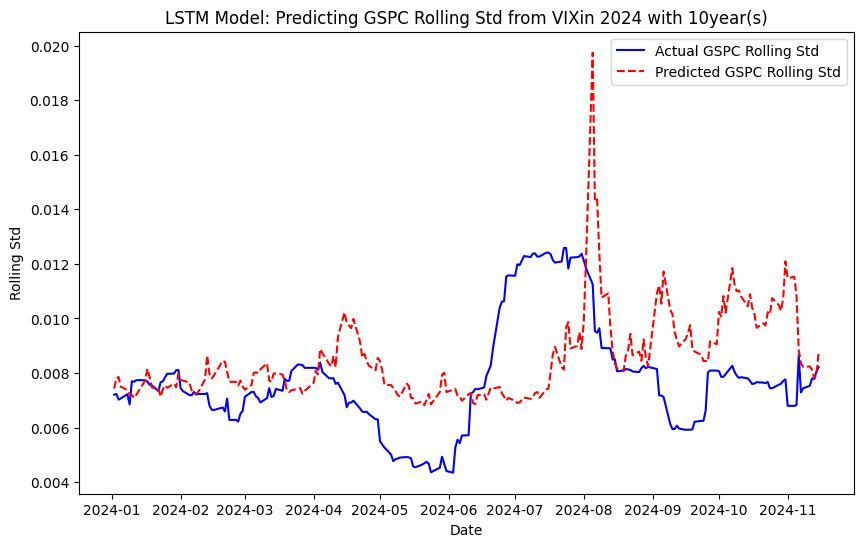

In [119]:
train_data_10 = data['2014-01-01':'2023-12-31']
test_data_1 = data['2024-01-01':]

predictions_rescaled, y_test_rescaled, mse = Model_LSTM(train_data_10, test_data_1)

print('Mean Squared Error:', mse)

Plot_LSTM(predictions_rescaled, y_test_rescaled, test_data_1.index, '10')